# Logistic Regression

In this notebook, we'll aim to illustrate examples of the following:

1. **Simple Logistic Regression.** Use one feature to make prediction (this will help us understand logistic regression).
2. **Multiple Logistic Regression.** Use two features and find decision surfaces, then use all features.
3. **Multi-Class Logistic Regression.** Explore how we can use logistic regression to classify more than two labels.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Simple Linear Regression

There exists a [small dataset](./ny_sf_apt.csv) on housing attributes in New York and San Francisco. We're going to look at this dataset in the context of simple logistic regression, i.e., using one feature to model the target, and multiple logistic regression, i.e., using multiple features to model the target.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_housing = pd.read_csv('./ny_sf_apt.csv')
df_housing.head()

FileNotFoundError: [Errno 2] No such file or directory: './ny_sf_apt.csv'

In [4]:
# This will help with plotting. Look up Pandas.Categorical for more methods ...
df_housing.loc[:, 'in_sf'] = df_housing['in_sf'].astype('category')

Our goal is to predict whether or not the house is `in_sf` or not (if it is not in SF, it is in NY). For the sake of simplicity, we'll split the data once, between a train set and a test set. *Of course, in practice, you'll want to cross validate with multiple splits of the data.*

In [5]:
df_train, df_test = train_test_split(df_housing,
                                     test_size=0.2, 
                                     random_state=42)

In [1]:
# We want to pick one feature to start that separates the two cases.
sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='in_sf');

NameError: name 'sns' is not defined

### Separability

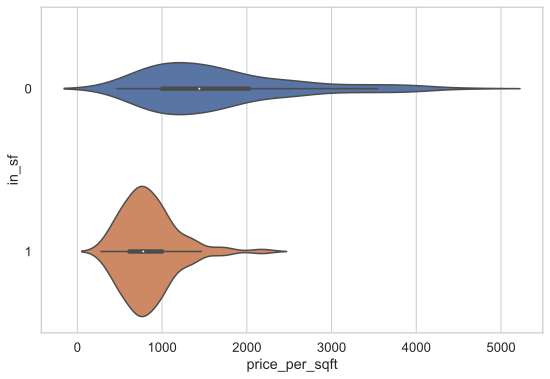

In [7]:
# `price_per_sqft` should work for our purposes
sns.violinplot(x='price_per_sqft',
               y='in_sf',
               data=df_train);

We would like for these distributions to be a bit more separated, especially since this is the only feature we're looking at for now. But, eventually we will add in more features which will give us more fidelity in our separation boundary.

Because there is only one feature (price per square foot), applying a scaler or normalizing (or even regularization!) is superfluous. To keep our results interpretable, we will stay with the unscaled feature.

### Model Summary

In [8]:
import statsmodels.api as sm

In [9]:
# For this first example, we'll employ statsmodels
lm_1 = sm.Logit(df_train['in_sf'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['price_per_sqft']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.486469
         Iterations 7


In [10]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  in_sf   No. Observations:                  393
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Jan 2021   Pseudo R-squ.:                  0.2950
Time:                        12:16:43   Log-Likelihood:                -191.18
converged:                       True   LL-Null:                       -271.18
Covariance Type:            nonrobust   LLR p-value:                 1.131e-36
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4721      0.375      9.269      0.000       2.738       4.206
price_per_sqft    -0.0030      0.000     -8.725      0.000      -0.004      -0.002
==================================================================================
"""

This is the standard Logistic Regression output for statsmodels. Focus on the following:

* **Log-Likelihood**: This is (the logarithm of) the probability we'd see these data ($(x, y)$ pairs) given our model of the relationship between the $x$ and $y$ (i.e., the sigmoid function we calculate). **You want this to be relatively close to zero.**

* **coef**: As you can see in the summary above, the linear **Model** here is using the Logit function as a link between our estimator, $p$, and the linear combination $X\beta=\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k$. In this way, we are modeling the *log-odds* by

$$
\text{logit}(p) = \log\left(\frac{p}{1 - p}\right) = \beta_0 + \beta_1 x_1 + \dots + \beta_k x_k
$$

So, *keeping all else held constant*, if we increase $x_i$ by one unit, the log-odds increases by $\beta_i$.

$$
\begin{align}
\log(\text{odds}_{new}) &= \log(\text{odds}_{original}) + \beta_i \newline
\text{odds}_{new} &= \exp\left[\log(\text{odds}_{original}) + \beta_i\right] \newline
&= \text{odds}_{original} \times e^{\beta_i}
\end{align}
$$

, where $\text{odds}_{new}$ is the odds after we increase $x_i$ by one unit, and $\text{odds}_{original}$ is the odds before we increased $x_i$ by one unit. This means that **for every unit increase in $x_i$, the odds is multiplied $e^{\beta_i}$ times.** In our case, for every dollar increase in price per square foot, the odds the apartment is in San Francisco is multiplied by by $e^{-0.0030} = 0.997$, or for every dollar increase in price per square foot, the odds of a San Francisco apartment goes down by less than a percentage point ($1 - 0.997 = 0.003$). It suffices to say that `e ** coef` is more interpretable than `coef`. (The intercept, **const**, represents the log-odds when all the feature values are equal to zero. This is more interpretable when you scale and normalize the features, but it's also used to determine a feature's value at the 50%-probability decision threshold, below ...)

* **std err**: In regression, we assume that error for a given $x$ value is normally distributed. So, the error for the coefficient (parameter) that we calculate has a normally distributed error. The **std err** is the estimated standard deviation of this error for each coefficient. More data tends to yeild smaller standard error values, and **smaller std err values tend to mean a more precise coefficient estimate.**

* **z**: This is based on a hypothesis test that the coefficient is zero. When **P>|x|** is small, there is very little evidence to suggest that our data (or more extreme data) is likely if we assume that the coefficient is zero. I.e., **if we assume the coefficient is zero, the probability of seeing our data (or something more extreme) is P>|x|**.

### "Prediction" Evaluation

Logistic regression actually outputs the *probability* of a house being in SF (or NY). This is called a *soft classification*. We classify whether or not a house is in NY or SF by setting a cutoff on the probability. By default, this cutoff is 50%, and hence we have what's called a *hard classification*.

Using the hard classification, we can evaluate our model by plotting results.

In [11]:
# Let's go down the sklearn path, since this is better used in model pipelines
from sklearn.linear_model import LogisticRegression

In [12]:
# By default, LogisticRegression will fit an intercept, as we did with statsmodels
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['price_per_sqft']], df_train['in_sf'])

LogisticRegression(C=100000, solver='newton-cg')

In [13]:
# We can see that the coefficient in question matches the one from statsmodels
print('intercept: ', round(lm_1.intercept_[0], 4))
print('price_per_sqft coef: ', round(lm_1.coef_[0][0], 4))

intercept:  3.4721
priece_per_sqft coef:  -0.003


In [14]:
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(df_test[['price_per_sqft']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['in_sf']

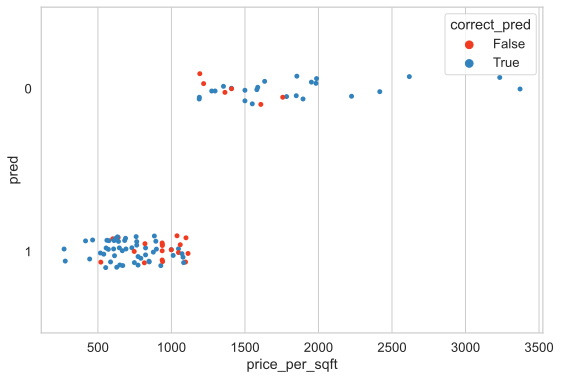

In [15]:
sns.stripplot(data=df_eval,
              x='price_per_sqft',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

The logistic regression has made a hard cutoff around 1200 sq ft: lower than that, the prediction is a SF apartment. Higher than that yeilds a NY apartment. You can see there's a good amount of error here ...

Recall that logistic regression is actually producing probabilities, and chooses a prediction based on a threshold.

In [16]:
# What are the first five results of logistic regression on the test set?
lm_1.predict_proba(df_test[['price_per_sqft']])[:5]

array([[0.33164487, 0.66835513],
       [0.44263237, 0.55736763],
       [0.18923929, 0.81076071],
       [0.23400866, 0.76599134],
       [0.17007468, 0.82992532]])

The first column of this array represents the probability that $y=0$, or the apartment is in NY, and the second column represents the probability that $y=1$, or the apartment is in SF.

In [17]:
# This is the same model but with proba (returns probabilities instead of class)
df_eval['proba_sf'] = lm_1.predict_proba(df_eval[['price_per_sqft']])[:, 1]

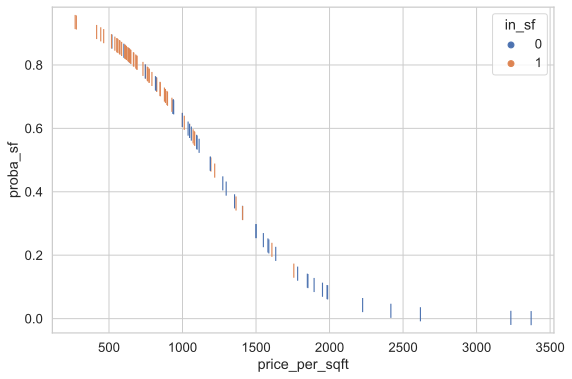

In [18]:
sns.scatterplot(data=df_eval,
                x='price_per_sqft',
                y='proba_sf',
                hue='in_sf',
                marker='|',
                s=200);

Simply using the probabilities in this plot is called a _soft classification_.

The 50% probability is reached when $\text{odds} = 1 \to \log(\text{odds}) = X\beta = 0$. So, recalling the intercept and coefficient from above, we have

$$
\begin{align}
0 &= \log(\text{odds}) \newline
\to \quad 0 &= \beta_0 + \beta_1 x_1 \newline
&= 3.4721 - 0.003 \cdot \texttt{price_per_sqft} \newline
0.003 \cdot \texttt{price_per_sqft} &= 3.4721 \newline
\to \quad \texttt{price_per_sqft} &= \frac{3.4721}{0.003} = 1157.367
\end{align}
$$

i.e. the actual cutoff is 1157.367 sq ft.

## Errors

What types of errors is this model making? From the graph, it looks like we are getting almost all the NY apartments right, and that our errors are coming from classifying some SF houses as NY houses. We are going to use the hard predictions to check with `confusion_matrix`.

In [19]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

In [20]:
confusion_matrix(df_eval['in_sf'], df_eval['pred'])

array([[24, 19],
       [ 6, 50]])

i.e. we get 

| | predict NY (0) | predict SF (1)|
|---|---|---|
| **is NY (0)** | 24 | 19|
| **is SF (1)** | 6 | 50 |

So, what happens when we move that threshold? This is where the Receiver Operating Characteristic comes in. We can plot for every threshold value how the False Positive Rate changes (FPR, or when we wrongly assign a SF label), and how the True Positive Rate (TPR, or when we correctly assign the SF label) for different thresholds.

In [21]:
fpr, tpr, thresholds = roc_curve(df_eval['in_sf'],
                                 df_eval['proba_sf'])

In [22]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

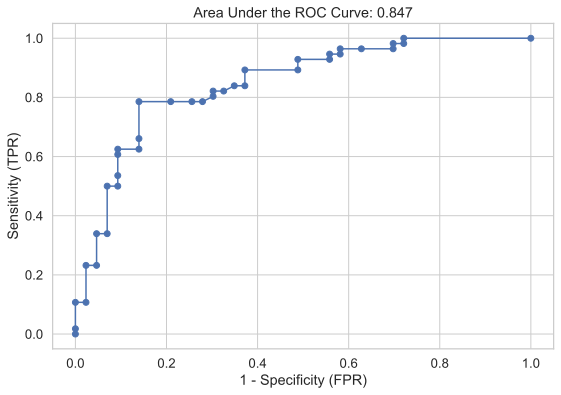

In [23]:
plot_roc(df_eval['in_sf'], df_eval['proba_sf'])

Each one of these points represents a different probability threshold, and the area under the curve (AUC) can be thought of as a measure of separability between the two classes (SF or NY) when we only use the features of the model. A perfect right angle is a perfect model (unrealistic), and a diagonal line is just as good as a flip of the coin. You can also use this to adjust the threshold in classification how you like.

Say we want to prioritize recall (i.e., True Positive Rate). That is, we want our model to find as many SF apartments as possible, even if some of them are actually NY apartments. Let's set a minimum of a 90% TPR.

In [24]:
mask = tpr > 0.9
thresholds[mask].max()

0.46672230061176256

In this case, you may want to pick all the rows where the probability is greater than 0.467.

## Multiple Logistic Regression

Let's return to the pairplot, and try to find a pair of features that indicates the best separation between NY and SF apartments. It looks like `price_per_sqft` and `elevation` separate fairly well.

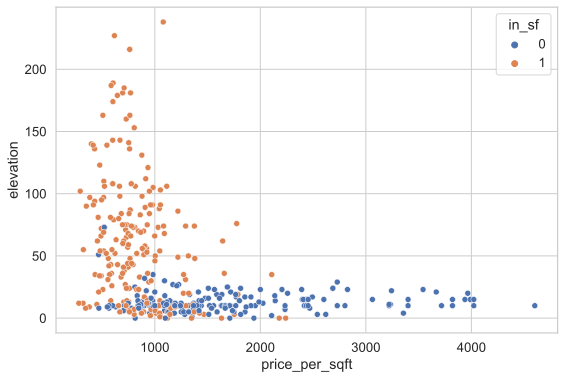

In [25]:
sns.scatterplot(data=df_train,
                x='price_per_sqft',
                y='elevation',
                hue='in_sf');

We can incorporate more features using the sklearn Logistic Regression implemetation.

In [26]:
features = ['price_per_sqft', 'elevation']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['in_sf']

In [27]:
lm_2 = LogisticRegression()  # We'll also regularize our features

In [28]:
lm_2.fit(X_train, y_train)

LogisticRegression()

In [29]:
X_test = scaler.transform(df_test[features])
preds = lm_2.predict(X_test)

In [30]:
confusion_matrix(df_test['in_sf'], 
                 preds)

array([[31, 12],
       [ 8, 48]])

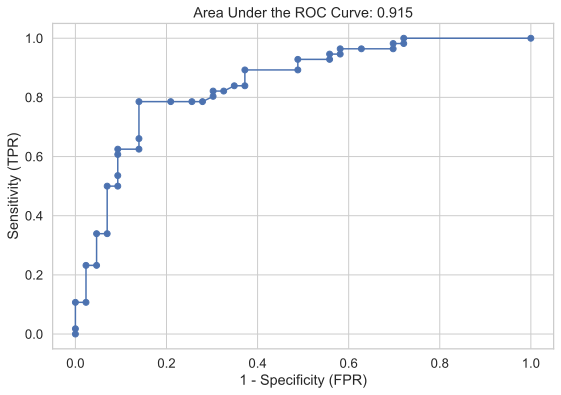

In [31]:
plot_roc(df_test['in_sf'], lm_2.predict_proba(X_test)[:, 1])

## Multi-class Logistic Regression

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
digits = datasets.load_digits(n_class=10)

In [33]:
def show_digits(digits, n=4):
    n = min(10, n)  # Set a maximum number to plot at 10
    
    images_and_labels = list(zip(digits.images, digits.target))
    
    for index, (image, label) in enumerate(images_and_labels[:n]):
        plt.subplot(2, 5, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %i' % label)
    
    plt.show()

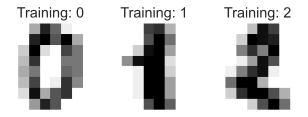

In [34]:
show_digits(digits, 3)

In [35]:
df_digits = pd.DataFrame(data=digits.data, columns=digits.feature_names)

In [36]:
df_digits['digit'] = digits.target

In [37]:
df_train, df_test = train_test_split(df_digits,
                                     test_size=0.2, 
                                     random_state=42)

We can pick between classifying in two different ways:

#### One vs. Rest (`ovr`)

For each class (in this case, for each number) we will have a separate logistic regression model. Each one of these models assigns a probability for whether an observation is that class, or is "one of the rest". So:

**Model 1:** Calculate $p_1 = P(y=1|x)$ where $y=1$ if the number is *one*, and $y=0$ otherwise

**Model 2:** Calculate $p_2 = P(y=1|x)$ where $y=1$ if the number is *two*, and $y=0$ otherwise

**Model 3:** Calculate $p_3 = P(y=1|x)$ where $y=1$ if the number is *three*, and $y=0$ otherwise

... and so on. Then, **we make the classification by picking the highest $p_i$ among all these models**.

#### Softmax (`multinomial`)

This actually introduces a **new link function**. So, rather than use the traditional sigmoid function here, we use the "softmax" function:

$$
\displaystyle \sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}{\text{ for }}i=1,\dotsc ,K{\text{ and }}\mathbf {z} =(z_{1},\dotsc ,z_{K})\in \mathbb {R} ^{K}
$$

So, again we have $k$ different models, but now we're saying that for each model, use a special link function that actually incorporates some aspect of the other link functions:

**Model 1:** Let $z_1 = \beta_{10} + \beta_{11}x_1 + \dots + \beta_{1k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_1$

**Model 2:** Let $z_2 = \beta_{20} + \beta_{21}x_1 + \dots + \beta_{2k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_2$

**Model 3:** Let $z_3 = \beta_{30} + \beta_{31}x_1 + \dots + \beta_{3k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_3$

... and so on. Notice that each model has its own set of coefficients $\beta_j$ and each link function actually uses the sum of these linear combinations from all the other models. In doing so, **the multinomial method creates a probability distribution among the possible classes**. Then, we just pick the highest probability among this distribution. This is nice for many reasons, and we'll see later that the same concept is actually used in many other aspects of Machine Learning.

In [38]:
lm_ovr = LogisticRegression(solver='newton-cg', multi_class='ovr')
lm_mn = LogisticRegression(solver='newton-cg', multi_class='multinomial')

In [39]:
X_train = df_train[digits.feature_names]
y_train = df_train['digit']

In [40]:
lm_ovr.fit(X_train, y_train)
lm_mn.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [41]:
preds_ovr = lm_ovr.predict(df_test[digits.feature_names])
preds_mn = lm_mn.predict(df_test[digits.feature_names])

In [42]:
confusion_matrix(df_test['digit'], 
                 preds_ovr)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 44,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  2,  0,  0,  0,  1,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3, 37]])

In [43]:
confusion_matrix(df_test['digit'], 
                 preds_mn)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 38]])

In [44]:
preds_proba_ovr = lm_ovr.predict_proba(df_test[digits.feature_names])
preds_proba_mn = lm_mn.predict_proba(df_test[digits.feature_names])

In [45]:
def get_multiclass_aucs(labels, scores, name='One-vs-Rest', kind='ovr'):
    ohe = OneHotEncoder()
    labels_ohe = ohe.fit_transform(labels)
    labels_ohe = labels_ohe.toarray()
    
    print(f'Average: {roc_auc_score(labels_ohe, scores, multi_class=kind)}')
    
    auc_scores = roc_auc_score(labels_ohe, scores, multi_class=kind, average=None)
    auc_scores = {i:s for i, s in enumerate(auc_scores)}
    
    return auc_scores

In [46]:
print("One-vs-Rest\n")
get_multiclass_aucs(df_test[['digit']], preds_proba_ovr)

One-vs-Rest

Average: 0.9983830171563234


{0: 1.0,
 1: 0.9994621342512908,
 2: 0.999814660365119,
 3: 0.9994586791771923,
 4: 1.0,
 5: 0.998028686017266,
 6: 0.9972747252747253,
 7: 0.9973836160230963,
 8: 0.9954545454545454,
 9: 0.996953125}

In [47]:
print("Multinomial\n")
get_multiclass_aucs(df_test[['digit']], preds_proba_mn)

Multinomial

Average: 0.9989410491653089


{0: 1.0,
 1: 0.9995697074010327,
 2: 1.0,
 3: 0.9963009743774811,
 4: 0.9996538355026309,
 5: 0.9972129698864796,
 6: 0.9983296703296703,
 7: 0.9999097798628654,
 8: 0.9992929292929292,
 9: 0.999140625}

## A Few Extra Notes

### Cross-Entropy Loss

**Logistic regression does not maximize accuracy.**

Instead, logistic regression has a cost function (in the binary classification problem) of

$$
J_{\text{model}}(\beta) = -\frac{1}{m}\left(\sum_{i=1}^m y_i \ln p_i + (1-y_i) \ln (1-p_i)\right), \quad\quad p_i\text{ function of }\beta
$$

This is called the cross-entropy (and, it is also equal to the *negative* log-likelihood for our $\hat{p}$ estimator, which is something we want to maximize).

Here $y_i \in \{0,1\}$, so we can tell:
* when $y_i = 1$ (i.e. the house is actually in SF), the contribution is $-\ln p_i$. The closer $p_i$ is to 1, the smaller the cost. If $p_i = 0$ (that is, we claimed it was impossible for this house to be in SF) then we incur an infinite penalty.
* when $y_i = 0$ (i.e. the house is actually in NY), the contribution is $-\ln(1-p_i)$. The closer $p_i$ is to 0, the smaller the penalty. If we claimed $p_i = 1$ (i.e. this house in NY *must* be in SF) then we incur an infinite penalty.

The effect is that we are trying to get the model to optimize the probabilities by giving **small cost to those it gets right with high confidence**, a medium cost to those it waffles on (i.e. doesn't commit one way or the other), and a **high cost to those that it predicts with high confidence but gets wrong**.

### The `C` parameter

In linear regression, we had a $\lambda$ parameter that controlled regularization:
$$J_{\text{linear}} = J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \lambda \sum_{i\neq 0} |\beta_i|^q$$
where $q = 1$ is LASSO and $q=2$ is Ridge. If $\lambda = 0$, we were turning off regularization. The model cost was generally MAE or MSE.


In logistic regression, we have a $C$ parameter that controls regularization. We have
$$J_{\text{logistic}} = C J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \frac{1}{2}\sum_{i\neq 0} |\beta_i|^2 \text{ or } \sum_{i\neq 0} |\beta_i| $$
i.e. the regularization term is always present, and setting $C=0$ turns the model part off (i.e. it doesn't matter how much you miss the points by). So for logistic regression, high C means "lots of model importance, so regularization's effect is small" whereas low C means "model importance is small, so regularization effect is large". 

I don't know why it is done this way!